In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import math

## Importing the drivingProfile

In [2]:
drivingProfile = pd.read_csv('./parameter.csv')

In [3]:
drivingProfile

,m,lf,lr,Cf,Cr,Iz,mu,steering_ratio,Sampling Period
0,1331,0.84,1.63,90624,90624,1500,0.5,0.0625,0.04


In [4]:
m = drivingProfile['m'][0]
lf = drivingProfile['lf'][0]
lr = drivingProfile['lr'][0]
Cf = drivingProfile['Cf'][0]
Cr = drivingProfile['Cr'][0]
Iz = drivingProfile['Iz'][0]
steering_ratio = drivingProfile['steering_ratio'][0]
Ts = drivingProfile['Sampling Period'][0]

## Importing inputs

In [5]:
inputs = pd.read_csv('./circular_input.csv')
inputs.head()

,samplingTime,Drv_DeltaSteer,Veh_Vx
0,0.000,0.0,30.000000
1,0.005,0.0,29.999664
2,0.010,0.0,29.998813
3,0.015,0.0,29.997596
4,0.020,0.0,29.996121


In [6]:
Time = inputs['samplingTime'].to_numpy()

print(Time)
print(len(Time))

deltaSteer = inputs['Drv_DeltaSteer'].to_numpy()

print(deltaSteer)
print(len(deltaSteer))

Vx = inputs['Veh_Vx'].to_numpy()

print(Vx)
print(len(Vx))

[0.000e+00 5.000e-03 1.000e-02 ... 9.990e+00 9.995e+00 1.000e+01]
2001
[0. 0. 0. ... 0. 0. 0.]
2001
[30.         29.99966417 29.99881271 ... 22.40103788 22.39962281
 22.39820783]
2001


In [7]:
n = math.floor(Ts/(Time[1]-Time[0]))
n

8

In [8]:
time = [Time[i] for i in range(len(Time)) if i%n==0]
steeringAngle = [deltaSteer[i] for i in range(len(deltaSteer)) if i%n==0]
velocity = [Vx[i] for i in range(len(Vx)) if i%n==0]

## Function to calculate parameters

In [9]:
def calculate_parameters(v_x):
  A = np.array([[(-2*Cf-2*Cr)/(m*v_x), -1-((2*Cf*lf - 2*Cr*lr)/(m*v_x*v_x))], [((2*Cr*lr)-(2*Cf*lf))/Iz, (-2*Cf*lf*lf-2*Cr*lr*lr)/(Iz*v_x)]])
  B = np.array([[(2*Cf)/(m*v_x), 0], [(2*Cf*lf)/Iz, 1/Iz]])
  C = np.array([[0, 1], [(-2*Cf-2*Cr)/m, -(2*Cf*lf-2*Cr*lr)/(m*v_x)]])
  D = np.array([[0, 0], [(2*Cf)/m, 0]])

  return [A, B, C, D]

## Controller Gain K

In [10]:
K = np.array([[1.8639, -0.0279],[-542794.8896, 32604.6225]])

## Observer Gain L

In [11]:
L = np.array([[-0.000000000009229, -0.000000000131049],[0.000000000135782, 0.000000001407986]])

## Matrix P
Positive definite P such that:  
![](./Screenshot%202023-05-30%20104347.png)  
`Amin, Amax` => Discrete-time closed loop matrices derived using the system equations fror v = vmin and v = vmax respectively.

In [12]:
P = np.array([[2, 1],[1,1]])
P

array([[2, 1],
       [1, 1]])

## Evaluating the system

In [13]:
u = [np.transpose(np.array([[deltaSteer[0]*math.pi/180, 0]]))]
x = [np.dot(np.linalg.inv(-K), u[0])]
x_cap = [np.dot(np.linalg.inv(-K), u[0])]
A, B, C, D = calculate_parameters(max(Vx))
y = [np.dot(C,x[0])]
y_cap = [np.dot(C,x_cap[0])]

for i in range(1, len(velocity)):
  A, B, C, D = calculate_parameters(velocity[i-1])

  out = signal.StateSpace(A, B, C, D)
  out = out.to_discrete(Ts)

  r = y[i-1] - y_cap[i-1]

  x.append(np.array(np.dot(out.A, x[i-1])+np.dot(out.B, u[i-1])))
  x_cap.append(np.array(np.dot(out.A, x[i-1])+np.dot(out.B, u[i-1]))+np.dot(L,r))

  y.append(np.dot(out.C, x[i-1])+np.dot(out.D, u[i-1]))
  y_cap.append(np.dot(out.C, x_cap[i-1])+np.dot(out.D, u[i-1]))

  utemp = np.dot(-K, x[i])
  utemp[0][0] += steeringAngle[i]*(math.pi/180)*steering_ratio
  u.append(utemp)

## Extracting the values from the lists

### Extracting `yaw moment -> Mz` and `steering angle -> beta` from `u[]`

In [14]:
Mz = []
delta = []
for i in range(len(u)):
    Mz.append(u[i][1][0])
    delta.append(u[i][0][0])
print(len(Mz), len(delta))
print(Mz)
print(delta)

251 251
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.3715422312786493e-12, -652.9832567487384, -1531.389209292028, -2420.648933596294, -3292.26591298289, -4159.198850270486, -5021.211229971462, -5873.258033015869, -6407.227717041457, -6518.057907765396, -6497.626706471233, -6449.140571287714, -6383.963322055539, -5715.335047807089, -4246.3881298248225, -2568.7674671478667, -926.0095883639517, -489.9014916690421, -1000.0540858566981, -1743.3253999845942, -2510.832290783048, -3271.3149575217335, -4029.2281611332323, -4786.42239186119, -5478.443282683864, -5692.199994963506, -5704.6

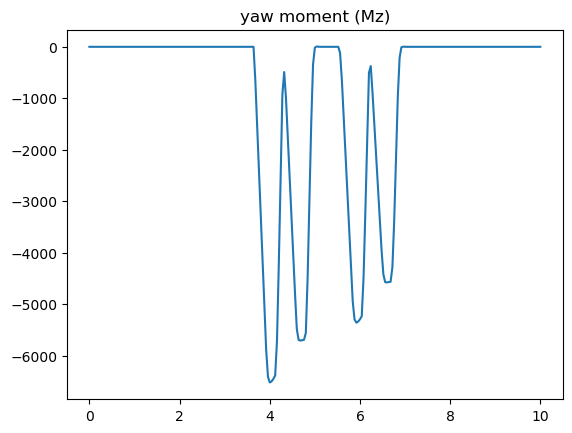

Text(0.5, 1.0, 'steering angle (delta)')

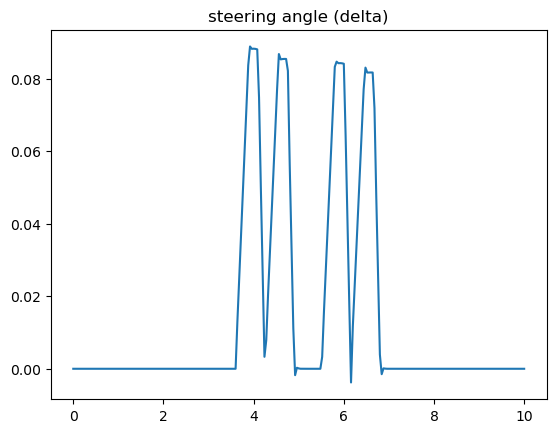

In [15]:
plt.plot(time, Mz)
plt.title("yaw moment (Mz)")
plt.show()
plt.plot(time, delta)
plt.title("steering angle (delta)")

### Extracting `sideslip angle -> beta` and `yaw rate -> r` from `x[] and x_cap[]`

In [16]:
'''
0 -> beta
1 -> r
'''
r = []
beta = []

for i in range(len(x)):
    r.append(x[i][1][0])
    beta.append(x[i][0][0])

print(len(beta), len(r))
print(beta)
print(r)

251 251
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8718495754612094e-18, 0.0013866136440904408, 0.002846304659023712, 0.004289288686798732, 0.005747452516432304, 0.007217312410320728, 0.00869695510478242, 0.010192264135221124, 0.010984383476013526, 0.011022623494076837, 0.011046173322531258, 0.011114655968306186, 0.011219868127209608, 0.009871208949131046, 0.006936106793714407, 0.003885523520211971, 0.0007836170207509574, 0.0009011794604952322, 0.0025826315139076354, 0.004309409299089203, 0.005989950433189859, 0.007663152906877871, 0.009338112785284543, 0.01101463115549483, 0.01

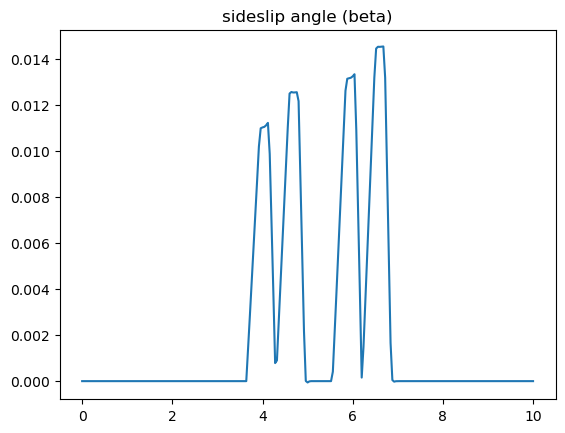

Text(0.5, 1.0, 'yaw rate (r)')

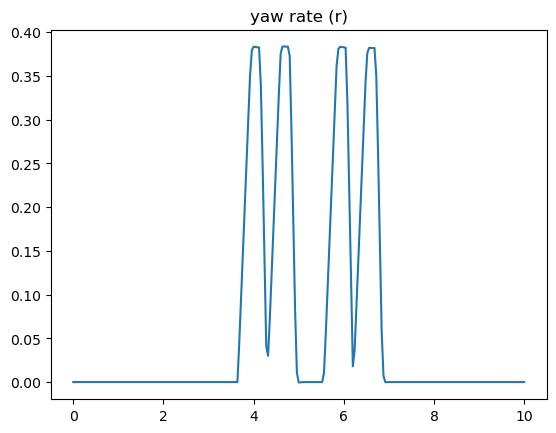

In [17]:
plt.plot(time, beta)
plt.title("sideslip angle (beta)")
plt.show()
plt.plot(time, r)
plt.title("yaw rate (r)")

In [18]:
'''
0 -> beta
1 -> r
'''
r_cap = []
beta_cap = []

for i in range(len(x)):
    r_cap.append(x_cap[i][1][0])
    beta_cap.append(x_cap[i][0][0])

print(len(beta_cap), len(r_cap))
print(beta_cap)
print(r_cap)

251 251
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8718495754612094e-18, 0.0013866136440904408, 0.002846304659023712, 0.004289288686798732, 0.005747452516432304, 0.007217312410320728, 0.00869695510478242, 0.010192264135221124, 0.010984383476013526, 0.011022623494076837, 0.011046173322531258, 0.011114655968306186, 0.011219868127209608, 0.009871208949131046, 0.006936106793714407, 0.003885523520211971, 0.0007836170207509574, 0.0009011794604952322, 0.0025826315139076354, 0.004309409299089203, 0.005989950433189859, 0.007663152906877871, 0.009338112785284543, 0.01101463115549483, 0.01

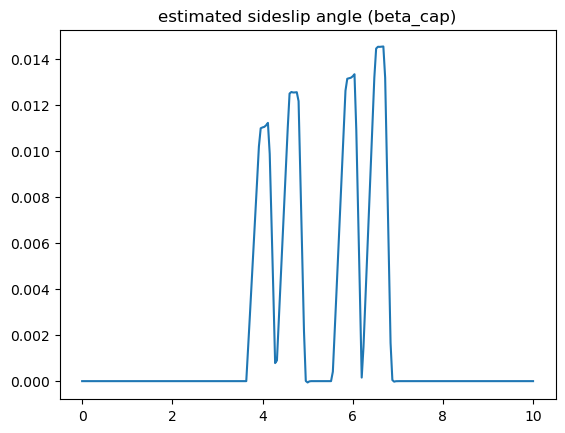

Text(0.5, 1.0, 'estaimated yaw rate (r_cap)')

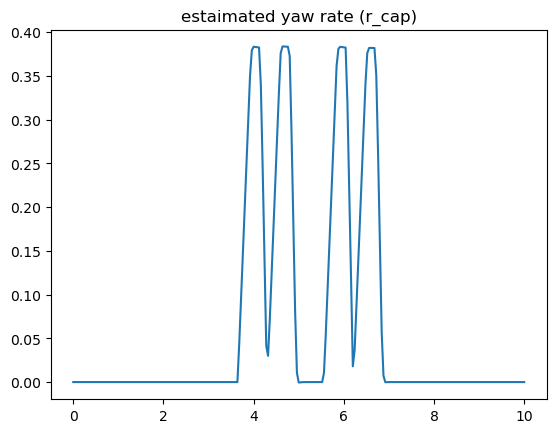

In [19]:
plt.plot(time, beta)
plt.title("estimated sideslip angle (beta_cap)")
plt.show()
plt.plot(time, r)
plt.title("estaimated yaw rate (r_cap)")

### Extracting `yaw rate -> r` and `inertial acceleration -> ay` from `y[] and y_cap[]`

In [20]:
'''
0 -> r
1 -> ay
'''
r1 = []
ay = []

for i in range(len(y)):
    r1.append(y[i][0][0])
    ay.append(y[i][1][0])

print(len(r1), len(ay))
print(r1)
print(ay)

251 251
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.98758298624351e-17, 0.043111373444383934, 0.09435314984722701, 0.14564968242799745, 0.19665781338584748, 0.24771699605598058, 0.2987881247797913, 0.34981441416986986, 0.3793785661290292, 0.3834143950090267, 0.38317981248140665, 0.3828328032488783, 0.38258533444117737, 0.3396259784810944, 0.2457096827657748, 0.14347075410364057, 0.04144666611708657, 0.030028168473299737, 0.07366726215970369, 0.12521079625212442, 0.17672790951270206, 0.22790741385208266, 0.27903736838217047, 0.33017121709943814, 0.3760082013532961, 0.38369500

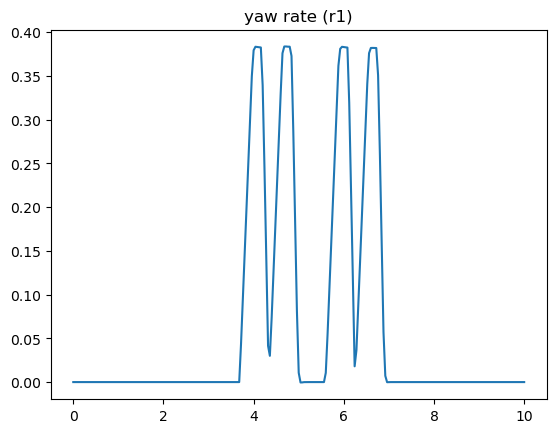

Text(0.5, 1.0, 'inertial acceleration (ay)')

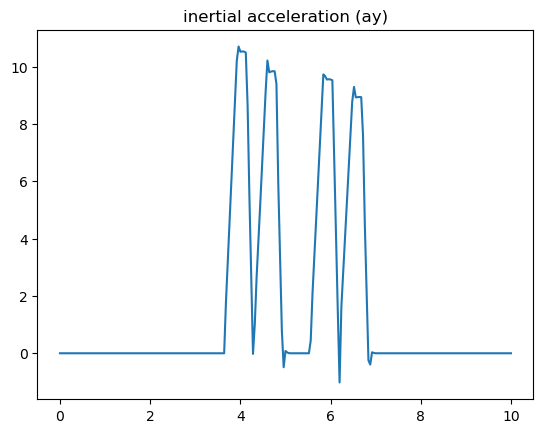

In [21]:
plt.plot(time, r1)
plt.title("yaw rate (r1)")
plt.show()
plt.plot(time, ay)
plt.title("inertial acceleration (ay)")

In [22]:
'''
0 -> r1
1 -> ay
'''
r1_cap = []
ay_cap = []

for i in range(len(y_cap)):
    r1_cap.append(y_cap[i][1][0])
    ay_cap.append(y_cap[i][0][0])

print(len(r1_cap), len(ay_cap))
print(r1_cap)
print(ay_cap)

251 251
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.7135780928985284e-15, 1.7825174845912928, 3.164016857037617, 4.570817746367345, 5.988626251555887, 7.397041382839823, 8.800447539294668, 10.199957263295964, 10.700814643422737, 10.515383784121031, 10.530037259924818, 10.52124416334654, 10.490169242249673, 8.66011456938376, 5.480832591421731, 2.734700816452534, -0.02270912322694396, 1.0297050736361393, 2.661033646959298, 3.9074074717742238, 5.192932698916878, 6.502915517391545, 7.8142630111679185, 9.124416490163835, 10.211106522275964, 9.800146522189054, 9.826558054489174, 9.8387

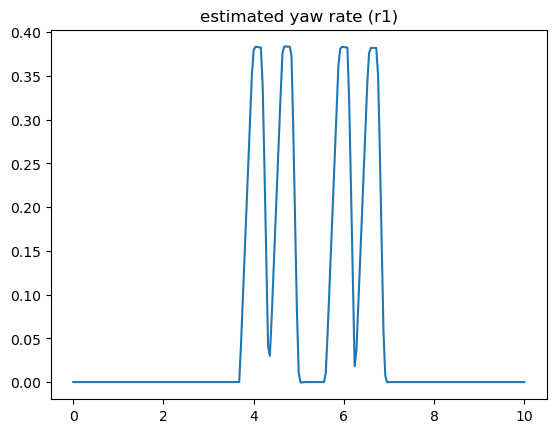

Text(0.5, 1.0, 'estimated inertial acceleration (ay)')

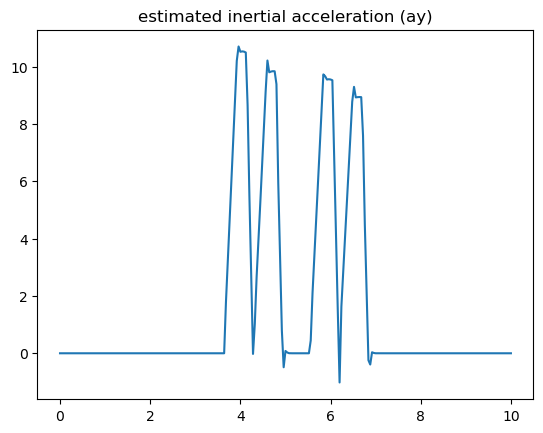

In [23]:
plt.plot(time, r1)
plt.title("estimated yaw rate (r1)")
plt.show()
plt.plot(time, ay)
plt.title("estimated inertial acceleration (ay)")

---

In [24]:
inputs = [[], []]

for i in range(len(u)):
    inputs[0].append(u[i][0][0])
    inputs[1].append(u[i][1][0])

inputs = np.array(inputs)

In [25]:
outputs = [[], []]

for i in range(len(y)):
    outputs[0].append(y[i][0][0])
    outputs[1].append(y[i][1][0])

outputs = np.array(outputs)

In [26]:
outputs.shape

(2, 251)

# Inserting noise to the output data

In [27]:
from sippy import functionset as fset

In [28]:
size = len(inputs[0])
noise = fset.white_noise_var(size, [0.001, 0.01])

In [29]:
noise.shape

(2, 251)

In [30]:
outputs.shape

(2, 251)

In [31]:
netOuput = outputs + noise

In [32]:
netOuput.shape

(2, 251)

---

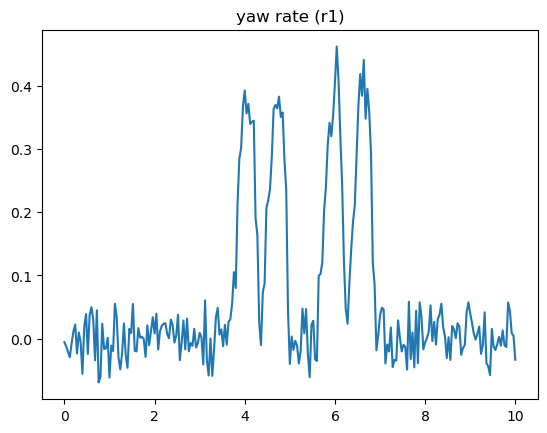

Text(0.5, 1.0, 'inertial acceleration (ay)')

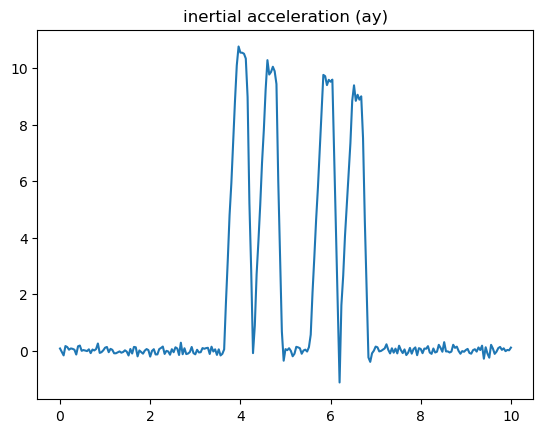

In [33]:
plt.plot(time, netOuput[0])
plt.title("yaw rate (r1)")
plt.show()
plt.plot(time, netOuput[1])
plt.title("inertial acceleration (ay)")

---
---

# SYSTEM IDENTIFICATION USING **SIPPY**

In [34]:
from sippy import system_identification
from sippy import functionset as fset
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

## Using input-output form

In [35]:
Id_ARMAXi = system_identification(outputs, inputs, 'ARMAX')
Id_ARMAXo = system_identification(outputs, inputs, 'ARMAX', ARMAX_mod = 'OPT')
Id_ARMAXr = system_identification(outputs, inputs, 'ARMAX', ARMAX_mod = 'RLLS')

In [36]:
# print(f"y[k] = {Id_ARMAXi.G}u[k] + {Id_ARMAXi.H}e[k]")
Id_ARMAXi.G

TransferFunction([[array([1.72749999]), array([-1.28220145e-05])], [array([142.50411739]), array([-8.148657e-05])]], [[array([ 1.        , -0.44848554]), array([ 1.        , -0.44848554])], [array([1.        , 0.28848948]), array([1.        , 0.28848948])]], 1.0)

In [37]:
Yout_ARMAXi = Id_ARMAXi.Yid

In [38]:
r2_score(outputs[0], Yout_ARMAXi[0])

0.9958521412110775

In [39]:
r2_score(outputs[1], Yout_ARMAXi[1])

0.9985744826128251

In [40]:
Yout_ARMAXo = Id_ARMAXo.Yid

In [41]:
r2_score(outputs[0], Yout_ARMAXo[0])

0.9962713857688215

In [42]:
r2_score(outputs[1], Yout_ARMAXo[1])

0.9999998305422705

In [43]:
Yout_ARMAXr = Id_ARMAXr.Yid

In [44]:
r2_score(outputs[0], Yout_ARMAXr[0])

0.9965207023165196

In [45]:
r2_score(outputs[1], Yout_ARMAXr[1])

0.9988779496830151

---
---
---

## Using State-Space form

In [46]:
METHOD = [
    'N4SID',
    'CVA', 
    'MOESP', 
    'PARSIM-S', 
    'PARSIM-P', 
    'PARSIM-K'
    ]

lege = ['System']

In [47]:
sysId = system_identification(netOuput, inputs, METHOD[1])

In [48]:
from sippy import functionsetSIM as fsetSIM

In [49]:
x_id, y_id = fsetSIM.SS_lsim_process_form(sysId.A, sysId.B, sysId.C, sysId.D, inputs, sysId.x0)

In [50]:
sysId.A.shape

(20, 20)

Text(0.5, 1.0, 'yaw rate r')

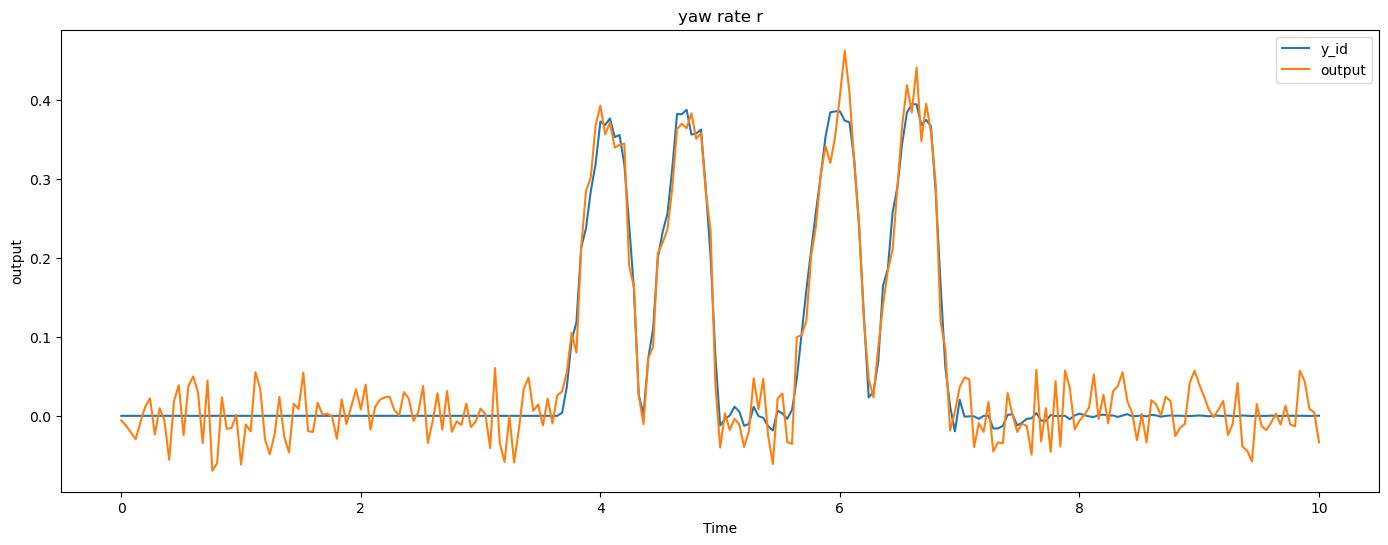

In [51]:
plt.figure(figsize=(17, 6))
plt.plot(time, y_id[0], label='y_id')
plt.plot(time, netOuput[0], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('yaw rate r')

Text(0.5, 1.0, 'inertial acceleration ay')

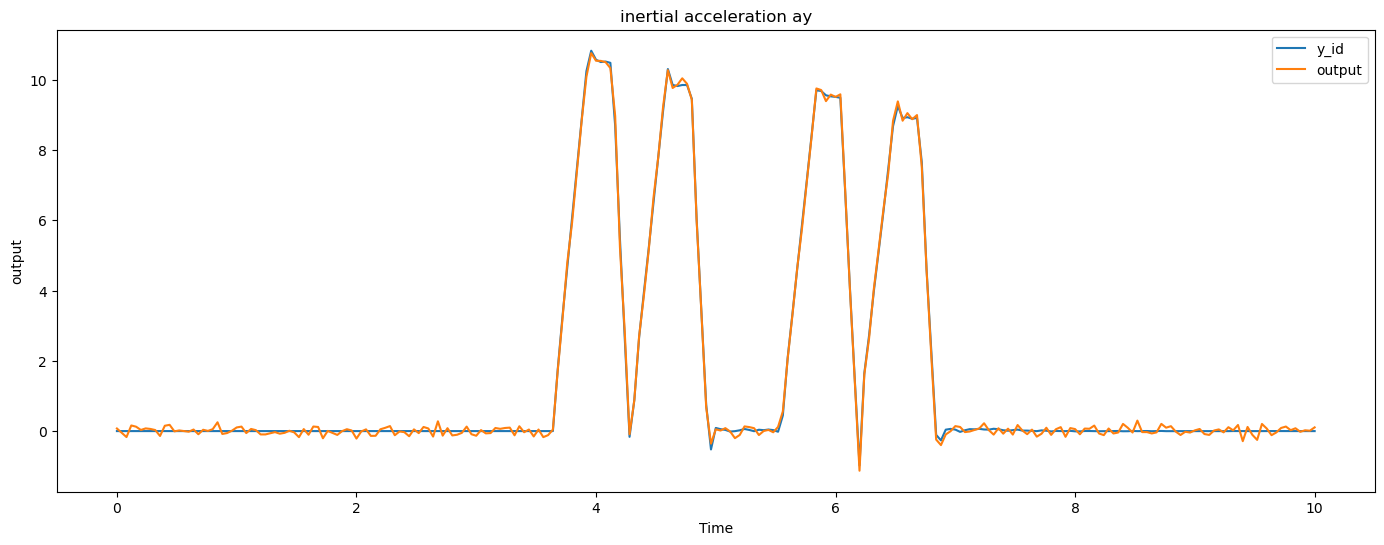

In [52]:
plt.figure(figsize=(17, 6))
plt.plot(time, y_id[1], label = 'y_id')
plt.plot(time, netOuput[1], label='output')
plt.legend()
plt.xlabel('Time')
plt.ylabel('output')
plt.title('inertial acceleration ay')

In [53]:
# for yaw rate
r2_score(netOuput[0], y_id[0])

0.9504038889785247

In [54]:
# for inertial acceleration ay
r2_score(netOuput[1], y_id[1])

0.998989126899164

---

In [55]:
# for yaw rate
math.sqrt(mean_squared_error(netOuput[0], y_id[0]))

0.028670287165451808

In [56]:
# for inertial acceleration ay
math.sqrt(mean_squared_error(netOuput[0], y_id[0]))

0.028670287165451808